In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet,ElasticNetCV,LassoCV, Lasso
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
%matplotlib inline


In [389]:
import warnings
warnings.filterwarnings('ignore')

In [390]:
np.random.seed(42)

In [391]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.shape

(1460, 81)

# Exploratary Data Analysis & Data Cleaning

In [153]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [154]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### Outliers

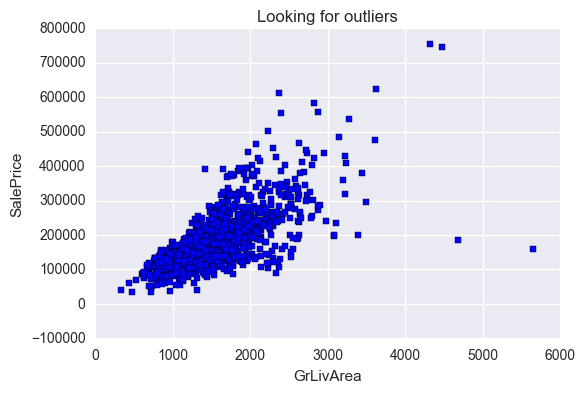

In [392]:
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

By ploting the SalePrice VS. GrLivArea, we find some outliers with more than 4000 GrLivArea. Credits to juliencs's pointing out this ( https://www.kaggle.com/juliencs/house-prices-advanced-regression-techniques/a-study-on-regression-applied-to-the-ames-dataset) 

In [393]:
train = train[train.GrLivArea < 4000]
# delete 4 rows; now 1456 rows

In [394]:
alldata = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

Take a deeper look at variables. Let's see what variables are numerical.

In [395]:
print(list(train.select_dtypes(include=[np.number]).columns.values))

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


Among those variables, many are actually categoraical. Also, variables about date need to be converted.

In [396]:
train["MoSold"].value_counts()
# MoSold: most sales are made in summer time (4 - 8)

6     253
7     233
5     204
4     141
8     122
3     106
10     88
11     79
9      63
12     59
1      56
2      52
Name: MoSold, dtype: int64

In [397]:
alldata['MoSold'] = ['Summer' if x in [4,5,6,7,8] else 'Winter' for x in alldata['MoSold']]

In [398]:
alldata["MoSold"].value_counts()

Summer    1854
Winter    1061
Name: MoSold, dtype: int64

In [399]:
# Convert year variable to numerical measurement: Take the difference between 2017 and the value of year variable
alldata["YearBuilt"] = 2017 - alldata["YearBuilt"]
alldata["YearRemodAdd"] = 2017 - alldata["YearRemodAdd"]
alldata["YrSold"] = 2017 - alldata["YrSold"]
alldata["GarageYrBlt"] = 2017 - alldata["GarageYrBlt"]

In [400]:
# Convert those "numerical" variables to categorical 
cat_var = ['MSSubClass',"OverallQual","OverallCond","MoSold"]
alldata[cat_var] = alldata[cat_var].astype(str)

### Missing Values

In [401]:
NA = alldata.isnull().sum()/alldata.shape[0]
NA = NA.to_frame(name='Percent')
NA.sort_values(by = ['Percent'],ascending=False).head(10)

,Percent
PoolQC,0.997256
MiscFeature,0.963979
Alley,0.932075
Fence,0.804460
FireplaceQu,0.487136
LotFrontage,0.166724
GarageYrBlt,0.054545
GarageFinish,0.054545
GarageQual,0.054545
GarageCond,0.054545


In [402]:
### I remove features which contain more than 20% Nan (Actually those are not very
### relavant to our interest).
alldata = alldata.drop(alldata[NA[NA.Percent > 0.2].index],1)

Fill missing values:   
- Numerical: using the median of the existing observations
- Categorical: using the most frequent value of the existing observations

In [403]:
### Show which column containing missing value is numerical column
missing = alldata.columns[pd.isnull(alldata).sum() > 0].tolist()
num_missing = list(alldata[missing].select_dtypes(include=[np.number]).columns.values)
print(num_missing)

['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']


In [404]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values = 'NaN', strategy = 'median', axis = 0)
alldata[num_missing] = imp.fit_transform(alldata[num_missing])

In [405]:
### Fill categorical NaN
alldata = alldata.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [406]:
# Now all NaN are gone
alldata.columns[pd.isnull(alldata).sum() > 0].tolist()

[]

Some numerical variables can be added to create new variables.

In [407]:
alldata['TotalSF'] = alldata['TotalBsmtSF'] + alldata['1stFlrSF'] + alldata['2ndFlrSF']
alldata['TotalBath'] = alldata["BsmtFullBath"] + alldata["FullBath"] + 0.5*alldata["BsmtHalfBath"] +0.5*alldata["HalfBath"]

### Log1p Transformation:
- SalePrice
- Some numerical variables

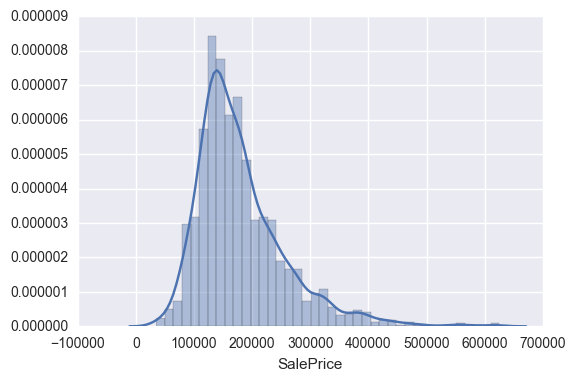

In [408]:
# SalePrice is skewed
sns.distplot(train.SalePrice)

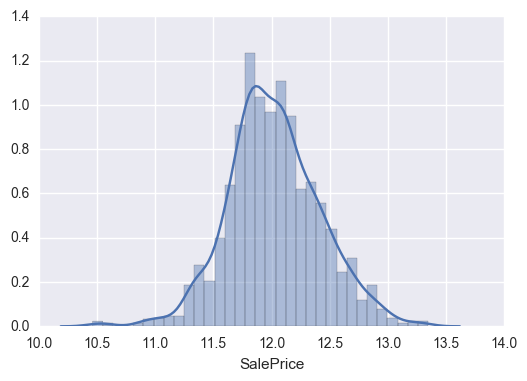

In [409]:
y = np.log1p(train['SalePrice'])

sns.distplot(y)

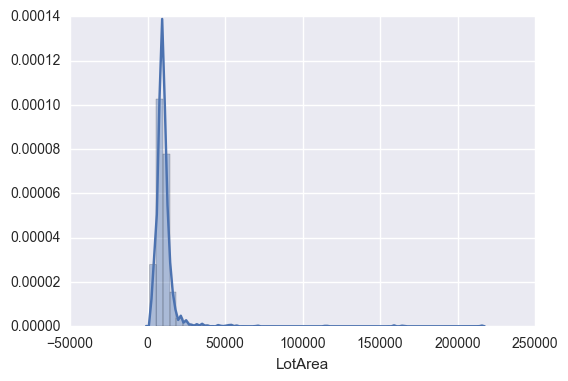

In [410]:
# Some variables are skewed
sns.distplot(train.LotArea)

In [411]:
from scipy.stats import skew
num_feats = list(alldata.select_dtypes(include=[np.number]).columns.values)
skewed_feats = alldata[num_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index


In [412]:
alldata[skewed_feats] = np.log1p(alldata[skewed_feats])

## Dummy variables for categorial features

In [413]:
num_feats

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'YrSold',
 'TotalSF',
 'TotalBath']

In [414]:
alldata.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF',"BsmtFullBath",
               "FullBath","HalfBath","BsmtHalfBath"], axis=1, inplace=True)

In [415]:
df = alldata.copy()

In [416]:
# standardize numerical features
num_feats = list(alldata.select_dtypes(include=[np.number]).columns.values)
df[num_feats] = (df[num_feats] - df[num_feats].mean())/df[num_feats].std()

In [417]:
# one hot encode
df = pd.get_dummies(df,drop_first=False)
df.shape

(2915, 297)

In [418]:
x = df[:train.shape[0]]
test = df[train.shape[0]:]
x.shape

(1456, 297)

In [419]:
train_clean = x.copy()
train_clean['SalePrice'] = y

In [41]:
#train_clean.to_csv('train_clean.csv', index =False) 

# Model Construction
## So far the data cleaning is done (hope so > <..)  
## The next step is feature engineering and model selection

First, let's see the correlations among different variables.

In [192]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [193]:
num_feats.append('SalePrice')

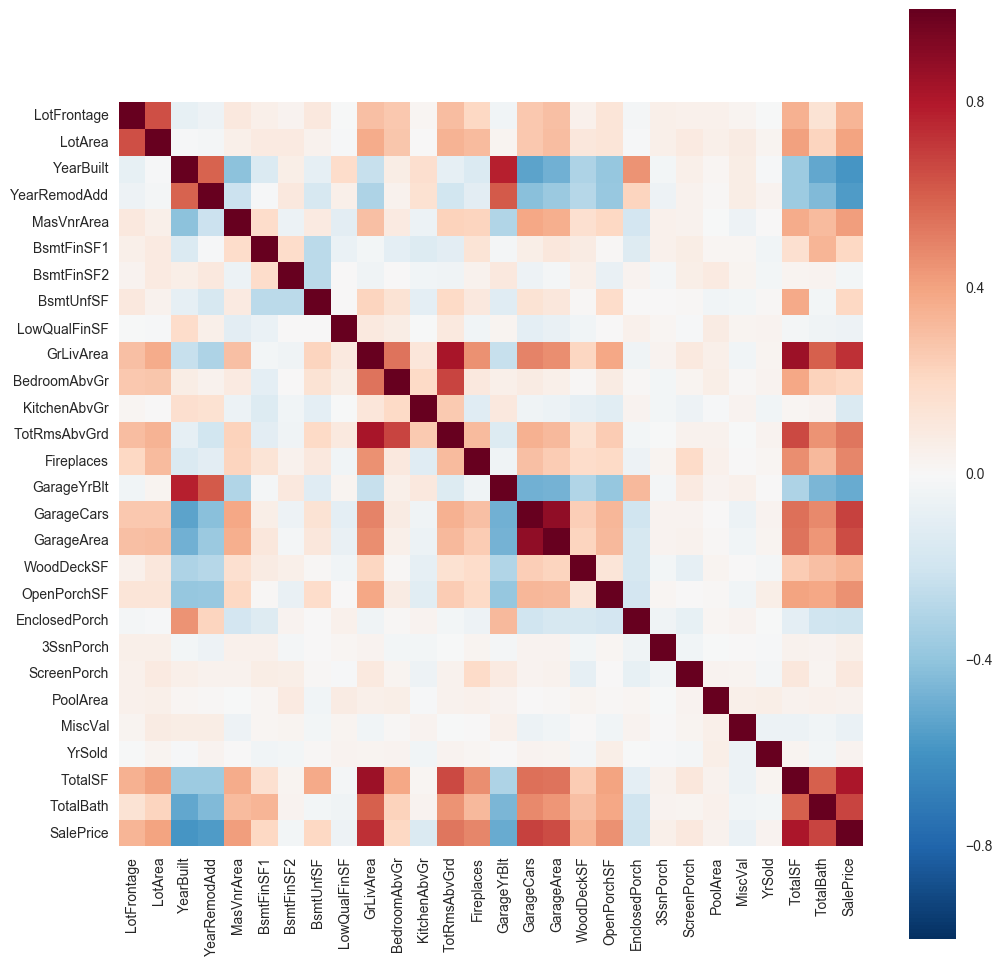

In [194]:
corr = train_clean[num_feats].iloc[:, :].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, vmax=1, square=True)

There are several things to note here:    
1 GarageYrBlt and YearBuilt are highly correlated       
2 GarageCars and GarageArea are highly correlated        
3 TotRmsAbvGrd and GrLivArea are highly correlated    
4 TotalSF and GrLivArea are highly correlated
5 LotArea and LofFrontage are highly correlared
    
These findings are not suprising. Garage is usually built with the house; garage size determines how many cars can be park in; TotalRmsAbvGrd, TotalSF and GrLivArea are all measuring the size of the house.
If we include all these variable into regression, multicollineraity may occur.

In [195]:
# See the correlation with SalePrice
np.abs(train_clean.corr()).sort_values(by = ['SalePrice'],ascending=False).SalePrice

SalePrice               1.000000
TotalSF                 0.814756
GrLivArea               0.732807
GarageCars              0.680408
TotalBath               0.672929
GarageArea              0.655212
ExterQual_TA            0.596304
YearBuilt               0.588977
GarageFinish_Unf        0.575923
YearRemodAdd            0.568986
BsmtQual_TA             0.539359
KitchenQual_TA          0.538949
TotRmsAbvGrd            0.533446
Foundation_PConc        0.531036
ExterQual_Gd            0.513608
GarageYrBlt             0.500812
Fireplaces              0.487126
HeatingQC_Ex            0.466697
OpenPorchSF             0.460923
BsmtQual_Ex             0.457864
BsmtFinType1_GLQ        0.438213
OverallQual_8           0.433495
MasVnrArea              0.415830
KitchenQual_Gd          0.415374
GarageFinish_Fin        0.415369
KitchenQual_Ex          0.406032
LotArea                 0.400138
MSSubClass_60           0.397094
MasVnrType_None         0.391148
GarageType_Detchd       0.389477
          

According to the heatmap, some variables are dependent on each other (strong correlation). Those variables which have less correlations with SalePrice will be removed. Those are "GarageYrBlt", "GarageArea", and "TotRmsAbvGrd"

## Random Forest

In [326]:
from sklearn.model_selection import KFold
kf = KFold(5, shuffle=True, random_state= 42)

In [323]:
l = [0.0 for feature in range(x.shape[1])]
feature_importance = np.array(l)

In [329]:
# Run Random Forests are 5-folds and average the feature importane score for each feature
names = x_train.columns

for train_index, test_index in kf.split(x):
    rf = RandomForestRegressor()
    rf.fit(x.iloc[train_index],y.iloc[train_index])
    feature_importance += rf.feature_importances_
    
feature_importance = feature_importance/5
feature_rank = sorted(zip(map(lambda x: round(x, 4), feature_importance), names),reverse=True)
features = [feature[1] for feature in feature_rank if feature[0] > 0] 

In [330]:
feature_rank

[(0.77280000000000004, 'TotalSF'),
 (0.043900000000000002, 'YearBuilt'),
 (0.043200000000000002, 'ExterQual_TA'),
 (0.029899999999999999, 'YearRemodAdd'),
 (0.029899999999999999, 'GarageArea'),
 (0.023199999999999998, 'TotalBath'),
 (0.0178, 'GarageCars'),
 (0.015900000000000001, 'KitchenQual_TA'),
 (0.015800000000000002, 'GrLivArea'),
 (0.015699999999999999, 'LotArea'),
 (0.0112, 'BsmtFinSF1'),
 (0.010699999999999999, 'CentralAir_Y'),
 (0.0097000000000000003, 'GarageYrBlt'),
 (0.0094999999999999998, 'BsmtUnfSF'),
 (0.0085000000000000006, 'CentralAir_N'),
 (0.0067000000000000002, 'Fireplaces'),
 (0.0055999999999999999, 'KitchenAbvGr'),
 (0.0053, 'LotFrontage'),
 (0.0044000000000000003, 'MSZoning_C (all)'),
 (0.0041999999999999997, 'OpenPorchSF'),
 (0.0041000000000000003, 'BsmtQual_Ex'),
 (0.0028999999999999998, 'OverallCond_3'),
 (0.0028, 'OverallQual_5'),
 (0.0027000000000000001, 'WoodDeckSF'),
 (0.0027000000000000001, 'TotRmsAbvGrd'),
 (0.0027000000000000001, 'MasVnrArea'),
 (0.00239

In [339]:
print('Feature Importance > 0:' + str(len(features)))
print('All features: '+ str(x_train.shape[1]))

Feature Importance > 0:203
All features: 297


Basically many features have 0 feature_importance in Random Forest. It suggest that those may be noise.

In [341]:
# Drop these highly correlaed features 
features.remove("GarageYrBlt")
features.remove("GarageArea")
features.remove("TotRmsAbvGrd")

In [350]:
x2 = x[features]
test2 = x[features]
print(x.shape)
print(x2.shape)

(1456, 297)
(1456, 200)


In [346]:
rf = RandomForestRegressor(random_state=42)
scorer = 'mean_squared_error'
cv_scores = cross_val_score(rf, x, y, cv = 5, scoring = scorer)
print(np.sqrt(-cv_scores).mean())

0.147910604962


In [420]:
cv_scores = cross_val_score(rf, x2, y, cv = 5, scoring = scorer)
print(np.sqrt(-cv_scores).mean())

0.14785110277


Without any tune parameter, the RMSLE of RF is around 0.15. Not good.

In [349]:
# Put different models' predictions on test set to a dataframe
rf.fit(x,y)
RandomForests = rf.predict(test)
performance = pd.DataFrame(RandomForests)
performance.columns = ['RandomForests']

## Support Vector Machine Regression

In [353]:
from sklearn.svm import SVR
svr = SVR(C=1.0, epsilon=0.2)
cv_scores = cross_val_score(svr, x, y, cv = 5, scoring = scorer)
print(np.sqrt(-cv_scores).mean())

0.136103192949


In [352]:
cv_scores = cross_val_score(svr, x2, y, cv = 5, scoring = scorer)
print(np.sqrt(-cv_scores).mean())

0.137131572687


In [431]:
svr.fit(x, y)
SupportVectorReg = svr.predict(test)
performance['SupportVectorReg'] = SupportVectorReg

## Ridge Regression

In [357]:
ridge = RidgeCV(alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75], cv = 10)
ridge.fit(x, y)
print(ridge.alpha_)
cv_scores = cross_val_score(ridge, x, y, cv = 5, scoring = 'mean_squared_error')
print(np.sqrt(-cv_scores).mean())

5
0.112215972614


In [358]:
cv_scores = cross_val_score(ridge, x2, y, cv = 5, scoring = 'mean_squared_error')
print(np.sqrt(-cv_scores).mean())

0.111525946257


In [359]:
ridge.fit(x, y)
RidgeRegression = lasso.predict(test)
performance['RidgeRegression'] = RidgeRegression

## Lasso Regression

Lasso picked 140 features and eliminated the other 157 features


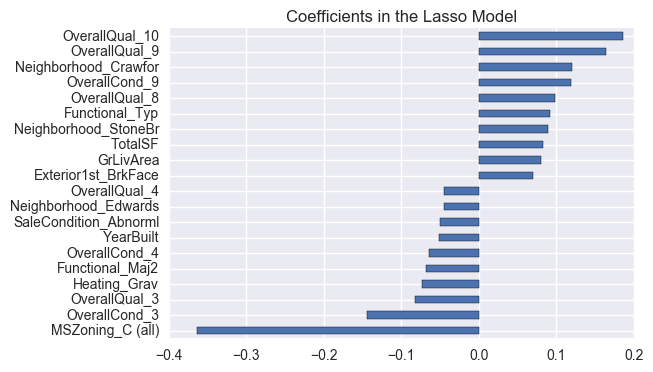

In [360]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(x, y)
coefs = pd.Series(lasso.coef_, index = x.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

In [361]:
lasso.alpha_

0.00029999999999999997

In [362]:
cv_scores = cross_val_score(lasso, x, y, cv = 5, scoring = 'mean_squared_error')
print(np.sqrt(-cv_scores).mean())

0.110146968292


In [363]:
cv_scores = cross_val_score(lasso, x2, y, cv = 5, scoring = 'mean_squared_error')
print(np.sqrt(-cv_scores).mean())

0.109887298486


Lasso's score is pretty good!

In [364]:
lasso.fit(x, y)
LassoRegression = lasso.predict(test)
performance['LassoRegression'] = LassoRegression

## Gradient Boosting

In [366]:
gbm = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber',random_state=42)

In [367]:
scorer = 'mean_squared_error'
cv_scores = cross_val_score(gbm, x, y, cv = 5, scoring = scorer)
print(np.sqrt(-cv_scores).mean())

0.116118692171


In [368]:
cv_scores = cross_val_score(gbm, x2, y, cv = 5, scoring = scorer)
print(np.sqrt(-cv_scores).mean())

0.114476819266


In [369]:
gbm.fit(x, y)
GradientBoosting = gbm.predict(test)
performance['GradientBoosting'] = GradientBoosting

## Elastic Net

In [371]:
EN = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
                                    l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000,random_state = 42)
EN.fit(x,y)

ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], copy_X=True,
       cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99], max_iter=5000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=42, selection='cyclic', tol=0.0001, verbose=0)

In [372]:
print(EN.alpha_)
print(EN.l1_ratio_)

0.0005
0.5


In [373]:
cv_scores = cross_val_score(EN, x, y, cv = 5, scoring = scorer)
print(np.sqrt(-cv_scores).mean())

0.110040786724


In [374]:
cv_scores = cross_val_score(EN, x2, y, cv = 5, scoring = scorer)
print(np.sqrt(-cv_scores).mean())

0.110363311158


In [376]:
EN.fit(x, y)
ElasticNet = EN.predict(test)
performance['ElasticNet'] = ElasticNet

### Adaboost

In [425]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

adb = AdaBoostRegressor(DecisionTreeRegressor(max_depth = 3), n_estimators = 3000, random_state = 42)
cv_scores = cross_val_score(adb, x, y, cv = 5, scoring = scorer)
print(np.sqrt(-cv_scores).mean())

0.176612957177


In [423]:
cv_scores = cross_val_score(adb, x2, y, cv = 5, scoring = scorer)
print(np.sqrt(-cv_scores).mean())

0.178416284447


In [428]:
adb.fit(x, y)
AdaBoost = adb.predict(test)
performance['AdaBoost'] = AdaBoost

In [432]:
performance.head()

,RandomForests,SupportVectorReg,RidgeRegression,LassoRegression,GradientBoosting,ElasticNet,AdaBoost
0,11.674136,11.688616,11.658351,11.702716,11.744739,11.705908,11.571327
1,11.958763,11.870262,11.952411,11.923271,11.950524,11.924464,11.775854
2,12.200603,12.147960,12.149480,12.129524,12.182306,12.128130,12.018483
3,12.172871,12.232643,12.201785,12.190972,12.210789,12.189378,12.125994
4,12.171486,12.117394,12.143982,12.190725,12.117605,12.191038,12.015636


## Final Training and Prediction

Now we have performance dataframe which contains the predictions from 5 different models. Based on the 5-fold cross validation on the training set, the rank is following:    
ElasticNet > Lasso > Ridge > Gradient Boosting > SVR > Random Forests > Adaboost   

Calculate the correlation for the purpose of emsemble.

In [433]:
performance.corr()

,RandomForests,SupportVectorReg,RidgeRegression,LassoRegression,GradientBoosting,ElasticNet,AdaBoost
RandomForests,1.000000,0.963268,0.966031,0.963910,0.967243,0.963676,0.960928
SupportVectorReg,0.963268,1.000000,0.986048,0.981175,0.977988,0.981009,0.960486
RidgeRegression,0.966031,0.986048,1.000000,0.996812,0.988077,0.996730,0.954990
LassoRegression,0.963910,0.981175,0.996812,1.000000,0.987604,0.999965,0.948061
GradientBoosting,0.967243,0.977988,0.988077,0.987604,1.000000,0.987773,0.951425
ElasticNet,0.963676,0.981009,0.996730,0.999965,0.987773,1.000000,0.947697
AdaBoost,0.960928,0.960486,0.954990,0.948061,0.951425,0.947697,1.000000


Basically, all models have very correlation with each other. The lowest is AdaBoost vs. ELasticNet but Adaboost doesn't perform well.

## Ensemble Learning: Stacking

In [444]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://7xlo8f.com1.z0.glb.clouddn.com/blog-diagram-stacking.jpg")

Stacking is an ensemble learning model. In this case, there are two layers of models: the first layer contains 5 differnt base models (can be SVM, GBM, Lasso, etc...).
- The training data will be divided into 5 folds. In each iteration, 4 out of 5 folds will be used for training each base model and the left one fold will be used for prediction.
- In addition, each base model will also make prediction on the whole test data in each interation.
- The prediction made by each base model on different folds will be bind to form a training set. This new training set is a "# of observations X # of Base models" matrix. In short, the column will be each base model since each one has its prediction on the whole training set. 
- The predictions on the test data will be taken average to form a new test set.
- The second layer model will be trained on the new training set (formed by base models' predictions on original training data), and the prediction will be made on the new test data. This prediction will be the final output.

In [434]:
class Ensemble(object):
    def __init__(self, n_folds, stacker, base_models):
        self.n_folds = n_folds
        self.stacker = stacker
        self.base_models = base_models
    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        folds = list(KFold(self.n_folds, shuffle=True, random_state=200).split(X))
        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[0], len(folds)))
            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                # y_holdout = y[test_idx]
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_holdout)[:]
                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict(T)[:]
            S_test[:, i] = S_test_i.mean(1)
        self.stacker.fit(S_train, y)
        y_pred = self.stacker.predict(S_test)[:]
        return y_pred

I pick 4 base models (gbm, lasso, EN, ridge) and use gbm as the second layer model.

In [440]:
# See its performance on 5-fold CV
stacking = Ensemble(5, gbm, [gbm,lasso,EN,ridge])
score = []
for train_index, test_index in kf.split(x):
    predict = stacking.fit_predict(x.iloc[train_index],y.iloc[train_index],x.iloc[test_index])
    score.append(rmse(predict, y.iloc[test_index]))

In [441]:
print(np.mean(score))

0.122146201553


In [442]:
score = []
for train_index, test_index in kf.split(x2):
    predict = stacking.fit_predict(x2.iloc[train_index],y.iloc[train_index],x2.iloc[test_index])
    score.append(rmse(predict, y.iloc[test_index]))
print(np.mean(score))

0.120202427391


Suprisingly, it is worse than single Lasso, ElasticNet and GBM.

## Take mean of different base models

In [480]:
def ensemble_mean(base_models,x,y):
    score = []
    for train_index, test_index in kf.split(x):
        x_train = x.iloc[train_index];y_train = y.iloc[train_index]
        x_test = x.iloc[test_index];y_test = y.iloc[test_index]
        prediction = np.array([0.0 for predict in range(x_test.shape[0])])
        for model in base_models:
            model.fit(x_train,y_train)
            prediction = prediction + model.predict(x_test)
        final_pred = prediction/(len(base_models))
        err = rmse(final_pred, y_test)
        score.append(err)    
    return np.mean(score)

base_models = [gbm,lasso,EN,ridge]
ensemble_mean(base_models,x,y)

0.10983522902949291

In [481]:
ensemble_mean(base_models,x2,y)

0.10947529547875264

According to the performance on 5-fold CV, the mean method of ensemble modeling gives the best local error.

## Submit Fianl Prediction

In [483]:
# Use mean of four base models
gbm.fit(x,y)
lasso.fit(x,y)
EN.fit(x,y)
ridge.fit(x,y)

gbm_p = gbm.predict(test)
lasso_p = lasso.predict(test)
EN_P = EN.predict(test)
ridge_p = ridge.predict(test)

Final = (gbm_p + lasso_p + EN_P + ridge_p)/4
Final = np.exp(Final) - 1

In [485]:
test_df = pd.read_csv("test.csv")

In [498]:
Prediction = pd.DataFrame({'Id': test_df.Id, 'SalePrice': Final})
Prediction.shape  #chek number of rows are correct

(1459, 2)

In [499]:
Prediction.to_csv('stacking.csv', index =False) 